In [1]:
import numpy as np
import xarray as xr 
from tqdm import tqdm
import matplotlib.pyplot as plt
import cmocean
from cmcrameri import cm
import cmasher
import cmaps
import cartopy.crs as ccrs
import cartopy.feature as cf
import glob
import dask.array as da
import time
from numpy import nan
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.interpolate import griddata

# organizing data for ice phenology validation 

In [2]:
# The satellite-derived lake ice phenology data (Wang et al. 2022) used for the validation are accessed from https://figshare.com/articles/dataset/Global_annual_lake_ice_phenological_dataset_1861-2099/19424801.
iceon_df = pd.read_csv('/proj/lhuang/LENS/OBS/satellite_ice_phenol_FL/Current_74245lks_2001-2020/ice_on_day.csv', header= 0)
iceoff_df = pd.read_csv('/proj/lhuang/LENS/OBS/satellite_ice_phenol_FL/Current_74245lks_2001-2020/ice_off_day.csv', header = 0)
iceduration_df = pd.read_csv('/proj/lhuang/LENS/OBS/satellite_ice_phenol_FL/Current_74245lks_2001-2020/ice_duration.csv', header = 0)
lake_info_df = pd.read_csv('/proj/lhuang/LENS/OBS/satellite_ice_phenol_FL/Lake_info_74245lks.csv', encoding_errors= 'replace')
# please note in our simulaiton, ice on date was counted as day of the year that ice starts to freeze, and ice off date was counted as the day of the year that ice melted
# to keep the consistency of ice on/off date between observation and model, we add the offset 214 here which does not alter the result of validation
iceduration_obs_clim = iceduration_df.iloc[:,1:].values.mean(axis = 1)
iceon_obs_clim = np.nanmean(np.where(iceon_df.iloc[:,1:].values >= 0, iceon_df.iloc[:,1:].values, np.nan), axis = 1) + 214
iceoff_obs_clim = np.nanmean(np.where(iceoff_df.iloc[:,1:].values >= 0, iceoff_df.iloc[:,1:].values, np.nan), axis = 1) + 214

In [3]:
# please refer to Huang et al. (2022) for the calculation of ice phenology in the CESM2-LE output 
# Huang, L. and others 2022. Emerging unprecedented lake ice loss in climate change projections. Nature Communications 13: 5798.
iceduration_mod_ensmean = xr.open_dataarray('/proj/lhuang/LENS/ICEDURATION_mod_ensmean.nc', cache = False)
iceon_mod_ensmean = xr.open_dataarray('/proj/lhuang/LENS/ICEON_mod_ensmean.nc', cache = False)
iceoff_mod_ensmean = xr.open_dataarray('/proj/lhuang/LENS/ICEOFF_mod_ensmean.nc', cache = False)
lake_ixy = xr.open_dataarray('/yourpath/lake_ixy.nc', cache = False)
lake_jxy = xr.open_dataarray('/yourpath/lake_jxy.nc', cache = False)

In [4]:
# you can find these model outputs in Huang et al., 2022
iceduration_mod_clim_2000_lunit = iceduration_mod_ensmean[:, lake_jxy, lake_ixy].sel(year = slice(2001,2020)).mean('year')
iceoff_mod_clim_2000_lunit = iceoff_mod_ensmean[:, lake_jxy, lake_ixy].sel(year = slice(2001,2020)).mean('year')
iceon_mod_clim_2000_lunit = iceon_mod_ensmean[:, lake_jxy, lake_ixy].sel(year = slice(2001,2020)).mean('year')
iceoff_mod_clim_2000_lunit = iceoff_mod_clim_2000_lunit[iceduration_mod_clim_2000_lunit > 0]
iceon_mod_clim_2000_lunit = iceon_mod_clim_2000_lunit[iceduration_mod_clim_2000_lunit > 0]
iceduration_mod_clim_2000_lunit = iceduration_mod_clim_2000_lunit[iceduration_mod_clim_2000_lunit > 0]
clm_lats = iceduration_mod_clim_2000_lunit.lat.values
clm_lons = iceduration_mod_clim_2000_lunit.lon.values
clm_lons = ((clm_lons + 180) % 360) - 180 #convert longitude from 0-359 to -180-179



In [5]:
obs_idx = np.arange(lake_info_df['Hylak_id'].size)
obs_lats = lake_info_df['Cen_lat'].values
obs_lons = lake_info_df['Cen_lon'].values

In [6]:
match_obs_idx =[]
match_clm_idx =[]
for i in np.arange(iceduration_mod_clim_2000_lunit.size):
    lat = clm_lats[i]
    lon = clm_lons[i]
    xx = obs_idx[np.abs(lat - obs_lats) < 0.94]
    yy = xx[np.abs(lon - obs_lons[xx]) < 1.25]
    if yy.size > 0: 
        match_obs_idx.append(yy[np.abs(iceduration_mod_clim_2000_lunit.values[i] - iceduration_obs_clim[yy]).argmin()])
        match_clm_idx.append(i)


# organizing data for lake surface temperature validation 

In [7]:
## The satellite-derived lake surface temperature (ARC-Lake v3; Merchant and MacCallum, 2018) used for the validation are accessed from https://researchdata.reading.ac.uk/186/
rec_day_ds = xr.open_dataset('/proj/lhuang/LENS/OBS/ARC_lake_V3/ARC_lake_Glob/REC/CA/SR/012/ALID9999_CGREC9D_CA012SR_mon_remapcon.nc', cache = False)
rec_night_ds = xr.open_dataset('/proj/lhuang/LENS/OBS/ARC_lake_V3/ARC_lake_Glob/REC/CA/SR/012/ALID9999_CGREC9N_CA012SR_mon_remapcon.nc', cache = False)

rec_day_night_ds = xr.concat((rec_day_ds,rec_night_ds),'ND')
obs_lswt = rec_day_night_ds.lswt.mean(axis = 0) - 273.15

obs_lswt_lunit = obs_lswt[:,lake_jxy,lake_ixy]
obs_lswt_lunit_summer = obs_lswt_lunit[6:9].mean('time')

obs_lswt_summer = obs_lswt[6:9].mean('time')


files = ['/proj/lhuang/LENS/TLAKE_MON/TLAKE_MON' + str(i) + '_LUNIT_allmembers.nc' for i in np.arange(7,10)]
tlake_mod_month_ds = xr.open_mfdataset(files,combine = 'nested',concat_dim='month')
tlake0_mon_clim = tlake_mod_month_ds.TLAKE.sel(year = slice(1995,2012)).isel(levlak = 0).mean(('year','ensemble')).compute() - 273.15
tlake0_summer = tlake0_mon_clim.mean('month')

x = iceduration_mod_ensmean[:, lake_jxy, lake_ixy].sel(year = slice(2001,2020)).mean('year')
tlake0_summer = tlake0_summer[x > 0 ]
obs_lswt_lunit_summer = obs_lswt_lunit_summer[ x> 0]
del x
gc.collect()



In [68]:
tlake0_summer_nonan = tlake0_summer[~np.isnan(obs_lswt_lunit_summer)]
obs_lswt_lunit_summer_nonan = obs_lswt_lunit_summer.dropna(dim = 'landunit')
tlake0_summer_nonan = tlake0_summer_nonan[tlake0_summer_nonan.lat.values > 0]
obs_lswt_lunit_summer_nonan = obs_lswt_lunit_summer_nonan[obs_lswt_lunit_summer_nonan.lat.values > 0]


Figure S1

In [81]:
x = [iceduration_obs_clim[match_obs_idx], iceon_obs_clim[match_obs_idx], iceoff_obs_clim[match_obs_idx], obs_lswt_lunit_summer_nonan]
y = [iceduration_mod_clim_2000_lunit[match_clm_idx], iceon_mod_clim_2000_lunit[match_clm_idx], iceoff_mod_clim_2000_lunit[match_clm_idx], tlake0_summer_nonan]
lim_min = [0, 250, 380, 0]
lim_max = [330, 420, 580, 32]
units = ['Days', 'Day of year', 'Day of year', '\u2103']
var_name =['Ice duration', 'Ice on date', 'Ice off date', 'Lake surface temperature \n in summer (JAS)']

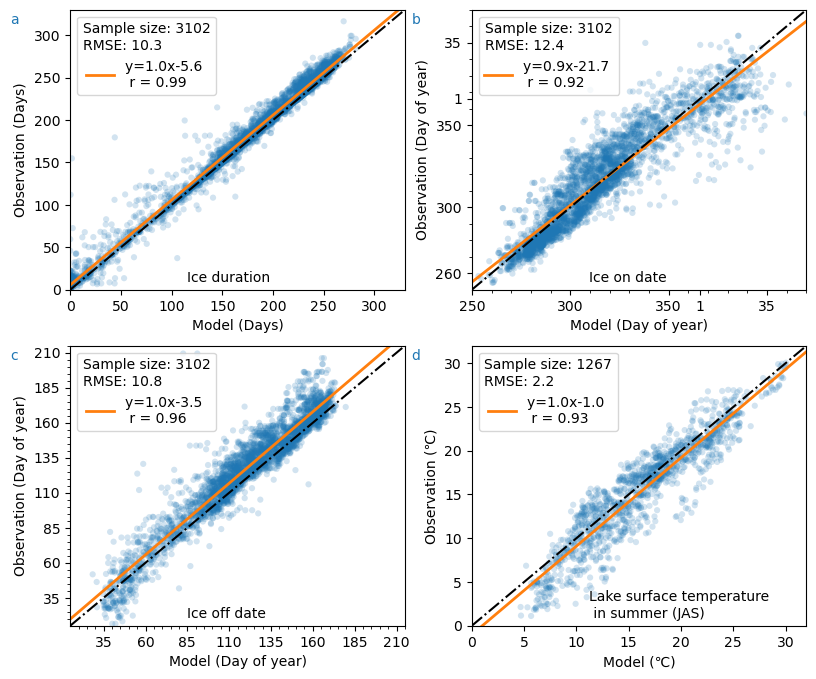

In [85]:
fig, axs = plt.subplots(2,2, figsize = (9.5,8))
#plt.subplots_adjust(wspace= 0.05, hspace=0.05)
axs = axs.flatten()
for i in np.arange(axs.size):
    axs[i].scatter(y[i],
                   x[i],
                   alpha = 0.2,
                   c = 'C0',
                   s = 20,
                   edgecolors = 'none')
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(y[i],x[i])
    rmse = np.sqrt(((slope * y[i] + intercept - x[i]) ** 2).mean()).values
    a = np.linspace(lim_min[i], lim_max[i], 6)
    b = slope*a + intercept
    axs[i].plot(a,b,
                c ='C1', 
                zorder = 1, 
                lw = 2, 
                label ="y={0:.1f}x-{1:.1f} \n r = {2:.2f}".format(slope,abs(intercept),rvalue) )
    axs[i].plot([0, 1], [0, 1],'k-.' ,transform=axs[i].transAxes)
    axs[i].set_xlim((lim_min[i],lim_max[i]))
    axs[i].set_ylim((lim_min[i],lim_max[i]))
    axs[i].set_xlabel('Model (' + units[i] + ')')
    axs[i].set_ylabel('Observation (' + units[i]+ ')')
    axs[i].legend(title = 'Sample size: ' 
                  + str(x[i].size) 
                  + '\nRMSE: ' + '{:.1f}'.format(rmse),
                  #+ ' (' + units[i] + ')', 
          loc = 'upper left')
    axs[i].text(-0.18,0.95, ['a','b','c','d'][i], transform=axs[i].transAxes, c = 'C0')
    axs[i].text(0.35, 0.03, var_name[i], transform=axs[i].transAxes)
#-------------------------------------------------------------------
axs[1].set_xticks((250,300,350,366,400))
axs[1].set_xticklabels((250, 300, 350, 1, 35))
axs[1].set_yticks((260, 300, 350, 366, 400))
axs[1].set_yticklabels((260, 300, 350, 1, 35))
axs[1].minorticks_on()
#-------------------------------------------------------------------
axs[2].set_xticks(np.arange(400,576,25))
axs[2].set_xticklabels(np.arange(400,576,25) - 365)
axs[2].set_yticks(np.arange(400,576,25))
axs[2].set_yticklabels(np.arange(400,576,25) - 365)
axs[2].minorticks_on()
#-------------------------------------------------------------------

plt.show()